# **Построение модели, решающей поставленную задачу (предсказание возраста морского ушка)**

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45569  100 45569    0     0  32629      0  0:00:01  0:00:01 --:--:-- 32619


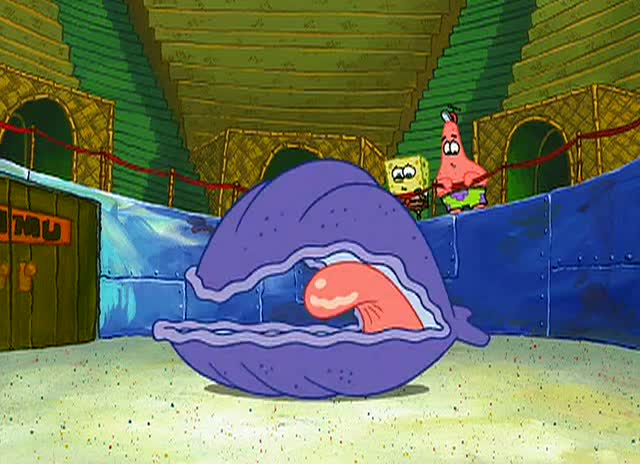

In [1]:
#@title Abalone
from google.colab.patches import cv2_imshow

!curl -o logo.png https://image.krasview.ru/video/7fe75dcace38695/_.jpg
import cv2
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

## Импорт библиотек и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ABALONE_DATASET = "https://raw.githubusercontent.com/aiedu-courses/stepik_eda_and_dev_tools/main/datasets/abalone.csv"

In [3]:
df = pd.read_csv(ABALONE_DATASET)

In [4]:
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


На прошлом этапе мы провели разведочный анализ данных. Сейчас пришло время построить несколько моделей

## Описание данных

`Sex` - категориальная - Пол (мужской, женский, младенец)

`Length` - непрерывная - мм - Измерение самой длинной части ракушки

`Diameter` - непрерывная - мм - Диаметр ерпендикулярен дине

`Height` - непрерывная - мм - Высота с мясом в раковине

`Whole weight` - непрерывная - граммы - Вес целиком со всеми запчастями

`Shucked weight` - непрерывная - граммы - вес мяса

`Viscera weight` - непрерывная - граммы - Вес внутренностей

`Shell weight` - непрерывная - граммы - Вес после сушки

`Rings` - целочисленная - Каждые 1,5 колца приравниваются к одному году (цель)

## Работа с пропущенными значениями

В целом, пропусков в данных не так много. Можно заполнить медианными значениями.

In [5]:
df.isnull().mean() * 100

Sex               0.000000
Length            0.000000
Diameter          2.370122
Height            0.000000
Whole weight      2.370122
Shucked weight    0.000000
Viscera weight    0.000000
Shell weight      1.197031
Rings             0.000000
dtype: float64

In [6]:
median_diameter = df['Diameter'].median()

df['Diameter'].fillna(median_diameter, inplace=True)

In [7]:
median_whole_weight = df['Whole weight'].median()

df['Whole weight'].fillna(median_whole_weight, inplace=True)

In [8]:
median_shell_weight = df['Shell weight'].median()

df['Shell weight'].fillna(median_shell_weight, inplace=True)

Убедимся, что пропусков больше нет

In [9]:
df.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

Также необходимо исправить ошибочные значения в поле Sex

In [10]:
df['Sex'] = df['Sex'].replace('f', 'F')

df['Sex'].value_counts()

F    1454
M    1447
I    1276
Name: Sex, dtype: int64

Дальше для удобства работы приведем названия колонок к нижнему регистру и заменим пробелы на нижнее подчеркивание

In [11]:
df.columns = df.columns.str.replace(' ','_').str.lower()

Исходный датасет содержит только одну категориальную переменную, все остальные переменные - числовые.

In [12]:
df.head(5)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.7985,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Построение моделей на числовых признаках (базовый подход)

В качестве первого подхода - построим несколько моделей с параметрами по умолчанию только на числовых признаках. Для этого выделим отдельно из датасета признаки и целевую переменную. И разобьем наши данные на тренировочную и тестовые выборки.

In [13]:
X = df.drop(columns=['sex', 'rings'])
y = df['rings']

In [14]:
X.shape, y.shape

((4177, 7), (4177,))

Оставим на тестовую выборку 25% от всех данных.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Наивный байес не очень подходит для задач регрессии, поэтому из минимума остается только метод ближайших соседей. Также добавим линейную регрессию, метод опорных векторов, случайный лес, градиентный бустинг из sklearn и LightGBM. Обернем все вычисления в пайплайн: первым шагом будет являться масштабирование, после чего последует обучение каждой модели.

Обобщающую способность каждого алгоритма проверим следующим образом: в цикле выполним трехблочную перекрестную проверку для каждого алгоритма и усредним результат. Остановимся на метрике R2. На основе полученных результатов построим график.

KNN_scaled: 0.455912 (0.013152)
LR_scaled: 0.483736 (0.008039)
SVR_scaled: 0.520456 (0.005448)
RF_scaled: 0.528718 (0.020338)
GB_scaled: 0.526850 (0.018417)
LGBM_scaled: 0.517293 (0.015948)


[Text(1, 0, 'KNN_scaled'),
 Text(2, 0, 'LR_scaled'),
 Text(3, 0, 'SVR_scaled'),
 Text(4, 0, 'RF_scaled'),
 Text(5, 0, 'GB_scaled'),
 Text(6, 0, 'LGBM_scaled')]

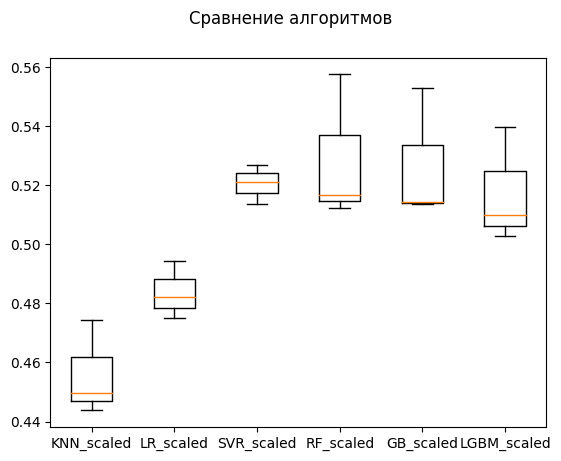

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

pipelines = []
pipelines.append(('KNN_scaled', (Pipeline([('scaled', StandardScaler()), ('KNN', KNeighborsRegressor())]))))
pipelines.append(('LR_scaled', (Pipeline([('scaled', StandardScaler()), ('LR', LinearRegression())]))))
pipelines.append(('SVR_scaled', (Pipeline([('scaled', StandardScaler()), ('SVR', SVR())]))))
pipelines.append(('RF_scaled', (Pipeline([('scaled', StandardScaler()), ('RF', RandomForestRegressor())]))))
pipelines.append(('GB_scaled', (Pipeline([('scaled', StandardScaler()), ('GB', GradientBoostingRegressor())]))))
pipelines.append(('LGBM_scaled', (Pipeline([('scaled', StandardScaler()), ('LGBM', LGBMRegressor())]))))

model_name = []
results = []
for pipe, model in pipelines:
  crossv_results = cross_val_score(model, X_train, y_train, cv=3, scoring='r2')
  results.append(crossv_results)
  model_name.append(pipe)
  msg = "%s: %f (%f)" % (model_name[-1], crossv_results.mean(), crossv_results.std())
  print(msg)

fig = plt.figure()
fig.suptitle('Сравнение алгоритмов')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(model_name)

Все модели показали довольно низкое качество на основе метрики R2. Линейная регрессия и метод ближайших соседей показали самый слабый результат. Далее тянется LGBM. И примерно одинаковый результат показали 3 модели: SVR, Random Forest, Gradient Boosting.

Применим перекрестную проверку на метрике MAE:

KNN_scaled: -1.687867 (0.047987)
LR_scaled: -1.662613 (0.072913)
SVR_scaled: -1.532034 (0.070070)
RF_scaled: -1.600322 (0.051740)
GB_scaled: -1.580203 (0.044897)
LGBM_scaled: -1.614692 (0.040572)


[Text(1, 0, 'KNN_scaled'),
 Text(2, 0, 'LR_scaled'),
 Text(3, 0, 'SVR_scaled'),
 Text(4, 0, 'RF_scaled'),
 Text(5, 0, 'GB_scaled'),
 Text(6, 0, 'LGBM_scaled')]

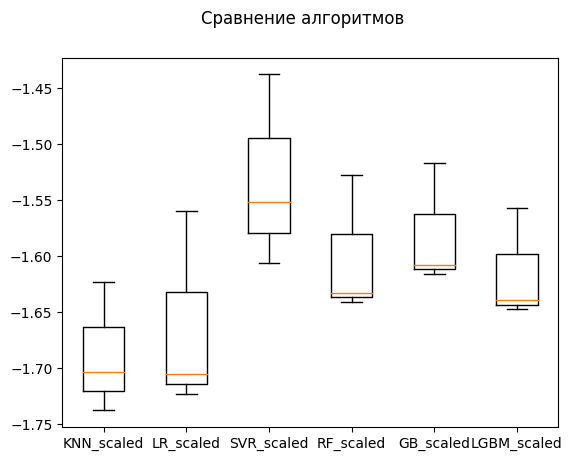

In [35]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

pipelines = []
pipelines.append(('KNN_scaled', (Pipeline([('scaled', StandardScaler()), ('KNN', KNeighborsRegressor())]))))
pipelines.append(('LR_scaled', (Pipeline([('scaled', StandardScaler()), ('LR', LinearRegression())]))))
pipelines.append(('SVR_scaled', (Pipeline([('scaled', StandardScaler()), ('SVR', SVR())]))))
pipelines.append(('RF_scaled', (Pipeline([('scaled', StandardScaler()), ('RF', RandomForestRegressor())]))))
pipelines.append(('GB_scaled', (Pipeline([('scaled', StandardScaler()), ('GB', GradientBoostingRegressor())]))))
pipelines.append(('LGBM_scaled', (Pipeline([('scaled', StandardScaler()), ('LGBM', LGBMRegressor())]))))

model_name = []
results = []
for pipe, model in pipelines:
  crossv_results = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')
  results.append(crossv_results)
  model_name.append(pipe)
  msg = "%s: %f (%f)" % (model_name[-1], crossv_results.mean(), crossv_results.std())
  print(msg)

fig = plt.figure()
fig.suptitle('Сравнение алгоритмов')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(model_name)

Видим, что все модели преуменьшают возраст ушек. В абсолютных значениях беспорным лидером является метод опорных векторов. В среднем он недосчитывает всего 1,5 кольца (1 год). Остальные модели ошибаются сильнее. Представительницы прекрасного пола морских ушек отдают свое предпочтение KNN и Linear Regression (эти модели сильнее остальных занижают возраст).

Данный "усатый"график дает определенное понимание, насколько каждая модель чувствительна к выбору обучающего набора данных. Видим, что у SVR довольно широкий диапазон значений, и это позволяет нам судить о том, как модель будет работать в худшем и лучшем случае, когда мы применим ее к новым данным. В данном случае худший результат SVR будет равен лучшему результату Random Forest.

## Подбор гиперпараметров у каждой из моделей (только на числовых признаках)

На данном этапе попробуем увеличить обобщающую способность каждой модели, настроив их параметры. Для этого воспользуемся решетчатым поиском с перекрестной проверкой. Отберем для некоторых параметров модели ряд значений, на основе которых попробуем получить наиболее удачную комбинацию, дающую наилучший результат.

In [19]:
from sklearn.model_selection import GridSearchCV

#сетка параметров
parameters = \
    [ \
        {
            'model': [KNeighborsRegressor()],
            'model__n_neighbors': range(1, 30),
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['l1', 'l2']
        },
        {
            'model': [LinearRegression()]
        },
        {
            'model': [SVR()],
            'model__kernel': ['linear', 'rbf'],
            'model__C': [0.1, 1, 10, 100]
        },
        {
            'model': [RandomForestRegressor()],
            'model__n_estimators': np.arange(100, 1000, 100),
            'model__max_depth': np.arange(2, 20, 3)
        },
        {
            'model': [GradientBoostingRegressor()],
            'model__n_estimators': np.arange(100, 1000, 100),
            'model__max_depth': np.arange(2, 20, 3),
            'model__learning_rate': [0.03, 0.1]
        }
    ]

#оцениваем качество моделей на основе переданных параметров
result=[]
for params in parameters:
    #модель
    model = params['model'][0]
    params.pop('model')
    #пайплайн
    steps = [('scaled', StandardScaler()), ('model', model)]
    #кросс-валидация при помощи Grid Search
    grid = GridSearchCV(Pipeline(steps), param_grid=params, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid.fit(X_train, y_train)
    print(grid.best_estimator_, grid.best_score_, grid.best_params_, sep='\n')

Fitting 3 folds for each of 116 candidates, totalling 348 fits
Pipeline(steps=[('scaled', StandardScaler()),
                ('model',
                 KNeighborsRegressor(metric='l1', n_neighbors=23,
                                     weights='distance'))])
0.5157360189443189
{'model__metric': 'l1', 'model__n_neighbors': 23, 'model__weights': 'distance'}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Pipeline(steps=[('scaled', StandardScaler()), ('model', LinearRegression())])
0.48373592063692944
{}
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Pipeline(steps=[('scaled', StandardScaler()), ('model', SVR(C=10))])
0.5389404847388699
{'model__C': 10, 'model__kernel': 'rbf'}
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Pipeline(steps=[('scaled', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=8, n_estimators=300))])
0.540655206857496
{'model__max_depth': 8, 'model__n_estimators': 300}
Fitting 3 fold

Также отдельно подберем параметры для LGBM.

In [20]:
lg = LGBMRegressor()
lg_params = {'n_estimators': np.arange(100, 1000, 100),
            'max_depth': np.arange(2, 20, 3),
            'learning_rate': [0.03, 0.1]
          }

In [21]:
gs_lgbm = GridSearchCV(lg, lg_params, cv=3, scoring='r2', n_jobs=-1, verbose=2)

In [22]:
gs_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.1],
                         'max_depth': array([ 2,  5,  8, 11, 14, 17]),
                         'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
             scoring='r2', verbose=2)

In [23]:
gs_lgbm.best_params_

{'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 200}

In [24]:
gs_lgbm.best_estimator_, gs_lgbm.best_score_, gs_lgbm.best_params_

(LGBMRegressor(learning_rate=0.03, max_depth=5, n_estimators=200),
 0.5343324934135831,
 {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 200})

Подбор параметров почти не дал какого-либо значимого прироста качества относительно метрики R2. Попробуем сделать предсказания с помощью моделей SVR, Random Forest, Gradien Boosting и LGBM и их лучших параметров. После чего оценим качество на других метриках.

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

svr = SVR(C=10)
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

r2_score(y_test, svr_pred), mean_absolute_error(y_test, svr_pred), mean_absolute_percentage_error(y_test, svr_pred)

(0.5485476925116184, 1.509878679664972, 0.14617055917923605)

In [30]:
rf = RandomForestRegressor(max_depth=8, n_estimators=300)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

r2_score(y_test, rf_pred), mean_absolute_error(y_test, rf_pred), mean_absolute_percentage_error(y_test, rf_pred)

(0.529881468778272, 1.5647334845094205, 0.15715050015584525)

In [32]:
gb = GradientBoostingRegressor(learning_rate=0.03, max_depth=5, n_estimators=200)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

r2_score(y_test, gb_pred), mean_absolute_error(y_test, gb_pred), mean_absolute_percentage_error(y_test, gb_pred)

(0.5281357556481232, 1.5497853503039685, 0.15506829366977795)

In [37]:
lgbm = LGBMRegressor(learning_rate=0.03, max_depth=5, n_estimators=200)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

r2_score(y_test, lgbm_pred), mean_absolute_error(y_test, lgbm_pred), mean_absolute_percentage_error(y_test, lgbm_pred)

(0.5466740687278401, 1.525735784540552, 0.15281894214625882)

Метод опорных векторов вновь переиграл именитых деревянных моделей. Ближе остальных подобрался LGBM. В целом все модели показали схожие результаты - все предсказывают возраст морского ушка с точностью в 84-85%. Что довольно-таки неплохой результат.

## Добавление категориальных признаков в лучшую модель

Как мы выяснили ранее, на числовых данных пальма первенства досталась методу опорных векторов. Попробуем теперь добавить единственную категориальную переменную из исходного датасета - пол морского ушка. Посмотрим, закрепит ли это окончательное лидерство за методом опорных векторов, либо у нас появится новый фаворит.

Создадим копию исходного датасета.

In [16]:
df2 = df[:]

In [17]:
df2.head(1)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15


На этот раз оставим признак пола.

In [18]:
X2 = df2.drop(columns=['rings'])
y2 = df2['rings']

По новой разобьем данные на тренировочную и тестовую выборки.

In [19]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X2, y2, test_size=0.25, random_state=42)

Попробуем отмасштабировать данные другим способом - MinMaxScaler. Также закодируем признал пол с помощью one hot encoding.

In [20]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

numeric_features = ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), ['sex']),
    ('scaling', MinMaxScaler(), numeric_features)
])

X_train_transformed = ct.fit_transform(X_train_full)
X_test_transformed = ct.transform(X_test_full)

Получим список с обновленными названиями колонок.

In [21]:
new_features = list(ct.named_transformers_['ohe'].get_feature_names_out())
new_features.extend(numeric_features)

Переведем данные обратно в датафреймы.

In [22]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=new_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=new_features)

X_train_transformed.head()

,sex_F,sex_I,sex_M,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
0,1.0,0.0,0.0,0.729730,0.672269,0.119469,0.374358,0.317754,0.345622,0.271550
1,1.0,0.0,0.0,0.594595,0.571429,0.123894,0.242253,0.188299,0.164582,0.217738
2,0.0,0.0,1.0,0.790541,0.798319,0.154867,0.559943,0.496638,0.460829,0.402093
3,0.0,0.0,1.0,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982
4,0.0,0.0,1.0,0.567568,0.579832,0.137168,0.285638,0.157028,0.151415,0.347285


Обучим SVR, Random Forest, Gradien Boosting и LGBM на параметрах, полученных через GridSearch на основе только числовых данных.

In [53]:
svr2 = SVR(C=10)
svr2.fit(X_train_transformed, y_train_full)
svr_pred2 = svr2.predict(X_test_transformed)

r2_score(y_test_full, svr_pred2), mean_absolute_error(y_test_full, svr_pred2), mean_absolute_percentage_error(y_test_full, svr_pred2)

(0.5369100626686572, 1.5129068637367822, 0.14489176497678122)

In [54]:
rf2 = RandomForestRegressor(max_depth=8, n_estimators=300)
rf2.fit(X_train_transformed, y_train_full)
rf_pred2 = rf2.predict(X_test_transformed)

r2_score(y_test_full, rf_pred2), mean_absolute_error(y_test_full, rf_pred2), mean_absolute_percentage_error(y_test_full, rf_pred2)

(0.5363936516033936, 1.5456585531699856, 0.1543026431578703)

In [55]:
gb2 = GradientBoostingRegressor(learning_rate=0.03, max_depth=5, n_estimators=200)
gb2.fit(X_train_transformed, y_train_full)
gb_pred2 = gb2.predict(X_test_transformed)

r2_score(y_test_full, gb_pred2), mean_absolute_error(y_test_full, gb_pred2), mean_absolute_percentage_error(y_test_full, gb_pred2)

(0.5348354513658681, 1.5293639040291742, 0.1522550395211223)

In [56]:
lgbm2 = LGBMRegressor()
lgbm2.fit(X_train_transformed, y_train_full)
lgbm_pred2 = lgbm2.predict(X_test_transformed)

r2_score(y_test_full, lgbm_pred2), mean_absolute_error(y_test_full, lgbm_pred2), mean_absolute_percentage_error(y_test_full, lgbm_pred2)

(0.5341527161284568, 1.53538536893199, 0.15205810538617756)

Можно сказать, что на модели с данным набором гиперпараметров признак пола почти не оказал никакого влияния. Попробуем заново провести решетчатый поиск, на этот раз с закодированной переменной пола морского ушка. Попробуем также поменять метрику с R2 на MAE.

In [63]:
#сетка параметров
parameters = \
    [ \
        {
            'model': [SVR()],
            'model__kernel': ['linear', 'rbf'],
            'model__C': [0.1, 1, 10, 100]
        },
        {
            'model': [RandomForestRegressor()],
            'model__n_estimators': np.arange(100, 1000, 100),
            'model__max_depth': np.arange(2, 20, 3)
        },
        {
            'model': [GradientBoostingRegressor()],
            'model__n_estimators': np.arange(100, 1000, 100),
            'model__max_depth': np.arange(2, 20, 3),
            'model__learning_rate': [0.03, 0.1]
        }
    ]

#оцениваем качество моделей на основе переданных параметров
result=[]
for params in parameters:
    #модель
    model = params['model'][0]
    params.pop('model')
    #пайплайн
    steps = [('scaled', StandardScaler()), ('model', model)]
    #кросс-валидация при помощи Grid Search
    grid = GridSearchCV(Pipeline(steps), param_grid=params, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
    grid.fit(X_train_transformed, y_train_full)
    print(grid.best_estimator_, grid.best_score_, grid.best_params_, sep='\n')

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Pipeline(steps=[('scaled', StandardScaler()), ('model', SVR(C=10))])
-1.4951928546864288
{'model__C': 10, 'model__kernel': 'rbf'}
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Pipeline(steps=[('scaled', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=8, n_estimators=300))])
-1.5324150451578704
{'model__max_depth': 8, 'model__n_estimators': 300}
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Pipeline(steps=[('scaled', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.03, max_depth=5,
                                           n_estimators=200))])
-1.5381646030561023
{'model__learning_rate': 0.03, 'model__max_depth': 5, 'model__n_estimators': 200}


Также отдельно подберем параметры для LGBM.

In [64]:
lg = LGBMRegressor()
lg_params = {'n_estimators': np.arange(100, 1000, 100),
            'max_depth': np.arange(2, 20, 3),
            'learning_rate': [0.03, 0.1]
          }

In [65]:
gs_lgbm2 = GridSearchCV(lg, lg_params, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

In [66]:
gs_lgbm2.fit(X_train_transformed, y_train_full)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.1],
                         'max_depth': array([ 2,  5,  8, 11, 14, 17]),
                         'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
             scoring='neg_mean_absolute_error', verbose=2)

In [67]:
gs_lgbm2.best_params_

{'learning_rate': 0.03, 'max_depth': 14, 'n_estimators': 100}

In [68]:
gs_lgbm2.best_estimator_, gs_lgbm2.best_score_, gs_lgbm2.best_params_

(LGBMRegressor(learning_rate=0.03, max_depth=14),
 -1.5341795421640756,
 {'learning_rate': 0.03, 'max_depth': 14, 'n_estimators': 100})

Среди всех моделей, обученных на параметрах, полученных при помощи GridSearchCV с метрикой MAE, наилучший скор также показал метод опорных векторов. Однако результат получился немного хуже нежели на GridSearchCV с метрикой R2.

Получается, что метод опорных векторов лучше остальных рассмотренных нами алгоритмов решает задачу определения возраста морских ушек.  

Так как GridSearch для SVR считается быстро, попробуем еще раз подобрать лучшие параметры. Расширим число подаваемых параметров в решетчатый поиск. Также попробуем использовать другую метрику - RMSE.

In [24]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

svr_params = {
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'C': [0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
              }

svr_gs = GridSearchCV(SVR(), svr_params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
svr_gs.fit(X_train_transformed, y_train_full)
svr_gs.best_estimator_, svr_gs.best_score_, svr_gs.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


(SVR(C=90), -2.2012256427905195, {'C': 90, 'kernel': 'rbf'})

Параметр kernel остался неизменным, а C изменился. Обучим с этим параметром финальную модель и посмотрим на метрики.

In [25]:
svr_ = SVR(C=90)
svr_.fit(X_train_transformed, y_train_full)
svr_pred_ = svr_.predict(X_test_transformed)

r2_score(y_test_full, svr_pred_), mean_absolute_error(y_test_full, svr_pred_), mean_absolute_percentage_error(y_test_full, svr_pred_)

(0.5565499514400969, 1.4873769918163564, 0.14351212374673156)

Получилось еще немного улучшить каждую из метрик. Однако мы по-прежнему ошибаемся в среднем на один год (1,5 кольца) в меньшую сторону. В среднем мы предсказываем возраст морского ушка с точностью 85%. На моем практике это первый случай, когда SVR показал результат лучше чем у ансамбли деревьев.

## Explainer Dashboard

In [26]:
!pip install explainerdashboard -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.3 MB/s eta 0:00:00


In [27]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [28]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [29]:
explainer = RegressionExplainer(svr_gs.best_estimator_, X_test_transformed.iloc[:1000], y_test_full.iloc[:1000])

Generating self.shap_explainer = shap.KernelExplainer(model, X)...


Чтобы успеть закончить задание до Нового Года, передадим в Explainer только первую тысячу строк.

In [30]:
db = ExplainerDashboard(explainer)

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


/usr/local/lib/python3.10/dist-packages/dash/dash.py:516: UserWarning: JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.


  0%|          | 0/1000 [00:00<?, ?it/s]

Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [31]:
db.run()

Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)


<IPython.core.display.Javascript object>

Dash app running on:


<IPython.core.display.Javascript object>

## Анализ модели в Explainer Dashboard

Вне зависимости от Importances type, и SHAP и Permutation выделяют все признаки, связанные с weight как самые важные. Тройка самых важных признаков в порядке убывания:
1. shucked weight
2. shell weight
3. whole weight  

* R2 = 0.593. Это означает, что 59.34% от всей дисперсии целевой переменной объясняется текущей моделью.
* MAPE = 0.152. Это означает, что в среднем наши прогнозы отклоняются от фактических значений на 15.25% как в большую так и в меньшую сторону.
* MAE = 1.753. Это означает, что в своих прогнозах мы ошибаемся, в среднем, на 1.753 кольца (чуть больше года).
* RMSE = 2.597 и MSE = 6.746. Данные метрики оценивают насколько близки предсказанные значения по отношению к фактическим значениям. Чем сильнее модель ошибается, тем следует более сильное наказание. Поэтому чем меньше значение у этих метрик, тем лучше.
  

Выловим наугад 2 морских ушка и посмотрим как наша модель справилась с индивидульными предсказаниями.
1. Первый лот - ушко под номером 505.  
Фактически ушко имеет 7 колец. А модель предсказала 6.826. То есть мы ошиблись всего на 2.5%. Что является очень хорошим результатом.  
Топ 3 признака:
* shell weight
* whole weight
* length

2. Лот номер 2 - ушко под номером 704.  
Фактически ушко имеет 11 колец. А модель предсказала 10.792. Нам снова удалось довольно точно определить возраст. В этом примере точность еще выше 98.1%. Ошибка всего 1.9%!  
Топ 3 признака:
* shucked weight
* shell weight
* whole weight

Чтобы не портить статистику самое время остановиться)

In [32]:
explainer.to_yaml('explainer.joblib', explainerfile='explainer.joblib')